#### Requirements  
 - Unpredictability. (Nearly) Impossible to predict next rn given the knowledge of all the past rn-s.  
    Note. Most of algorithms consists of two steps: entropy collection and entropy revealing. Unpredictability means impossibility to read result or make wanted number to be a result before entropy collection step.
 - Finality. All honest participants must generate the same rn.
 - Liveness. A rn will eventually be generated.
 - Unbiasedness. Distribution of rn cannot be influenced by a (small?) group of participants. In practice, it means that the generation ceremony cannot be influenced by selective participation of malicious participants.
 - Sufficiency. There are “enough” rn, i.e., rn-s are available at request.  

#### BFT RNG (in collaboration with Mikhail Krasnoselsky)

 - Statement 1. Let X1 be a uniform on {0, 1, …, N-1} random variable, which is independent of arbitrary measurable random variable X2. Then X1+ X2 mod N is the uniform on {0, 1, …, N-1} random variable.
 - Statement 2. Let X11 , …, X1M be a i.i.d. uniform on {0, 1, …, N-1} random variables, which is independent of arbitrary measurable random variable X21, …, X2M. Then X11+ X21 mod N, …, X1M+ X2M mod N are independent uniform on {0, 1, …, N-1}.  

#### Proposed algorithm:
 - secret sharing without a dealer based on polynomials and homomorphic encryption (https://ieeexplore.ieee.org/abstract/document/7520905).
 - Resulting RN – the value of a secret polynomial at a given point (for example, 0).

#### Properties
 - Each step results in unpredictable RN or revealing at least one faulty process. A faulty processes could only rip off during the “preparation step” without ability to influence on unpredictability.
 - Limitation: we need to know the list of participants as always in BFT.   
 - Other limitations:  
    Liveness: h >= d + 1, where h is the number of honest participants  
    Unpredictability: h >= 2 and f <= d + 1, where f is the number of faulty participants.  
    Classic result about BFT RNG: https://link.springer.com/chapter/10.1007/11945529_20 (разбор есть на нашей wiki).  

#### Related papers (RNG usage for PoS):  
    https://fc16.ifca.ai/bitcoin/papers/BGM16.pdf  
    https://link.springer.com/chapter/10.1007/978-3-319-63688-7_12  

In [1]:
# Количество участников:

n = 10
degree = 8

- В качестве homomorphic one-way function that satisfies $E(x + y) = E(x)*E(y)$ пока возьмём $E(x) = g^x$ над $Z_p^*$

In [2]:
import math
import random
import prime_number as pn

class EClass:
    def __init__(self, m, g = 13, p = 101):
        self.m = m
        self.g = g
        self.p = p
        
    def __mul__(self, other):
        if (self.g != other.g or
            self.p != other.p):
            raise Exception('g and n must be the same for both classes')
        return EClass(self.m + other.m, self.g, self.p)
    
    def __imul__(self, other):
        return self * other
    
    def calc(self):
        return self.g**(self.m % self.p)

In [3]:
g = pn.generate_prime_number(random.randint(32,64))
p = pn.generate_prime_number(random.randint(32,64))

A = EClass(10, g, p)
B = EClass(20, g, p)

print(f"E(x)*E(y) = {(A*B).calc()}")
print(f"E(x+y)    = {EClass(10 + 20, g, p).calc()}")

E(x)*E(y) = 18724827932323904425245538798982374276288035150628898410029550834314362252550177998555131511858470007372502756101202022669060047181647453328110034509951875121691747474845622543834253984032646684241151260303283760423870071016007405966526094838547522027264972961036038788487102730451463483804450104106183454936207632499624793915186287959913188098307232429228496950703449925255718830332175887842606302088000267609835844688183309062826525630621167764798558079049
E(x+y)    = 18724827932323904425245538798982374276288035150628898410029550834314362252550177998555131511858470007372502756101202022669060047181647453328110034509951875121691747474845622543834253984032646684241151260303283760423870071016007405966526094838547522027264972961036038788487102730451463483804450104106183454936207632499624793915186287959913188098307232429228496950703449925255718830332175887842606302088000267609835844688183309062826525630621167764798558079049


#### Для работы с полиномами сделаем класс, который поддерживает:
- сложение полиномов
- генерацию случайного полинома по заданной степени и значению в точке

In [4]:
class Polinomial:
    def __init__(self, coef = [0]):
        if type(coef) == int:
            coef = [coef]
        self.self_update(coef)

    def self_update(self, coef = []):
        new_coef = [0]
        for i, c in enumerate(coef[::-1]):
            if c != 0:
                new_coef = coef[:len(coef)-i]
                break
        self.coef = new_coef
        self.degree = len(new_coef) - 1
                
    def generate_polynomial(self, degree, a, b, c_range = 2**32):
        """chooses coefficients for a polynomial of the given degree, such that f(a) == b"""

        #to fit only one data point, we can choose arbitrary values for every coefficient except one, which we initially set to zero.
        coefficients = [0] + [int(c_range * random.random()) for _ in range(degree)]

        #now calculate f(a). This will probably not be equal to b, initially.
        y = sum(coefficient * a**n for n, coefficient in enumerate(coefficients))

        #setting the final coefficient to their difference will cause f(a) to equal b.
        coefficients[0] = b - y

        self.self_update(coefficients)
        
    def __getitem__(self, x):
        res = 0
        for i in range(self.degree + 1):
            res += self.coef[i] * x ** i
        return res
    
    def __add__(self, other):
        if type(other) != Polinomial:
            return self + Polinomial([other])

        A, B = self.coef, other.coef
        if self.degree > other.degree:
            A, B = B, A
        A = A + [0] * (len(B) - len(A))
        return Polinomial([A[i] + B[i] for i in range(len(A))])

    def __radd__(self, other):
        return self + other

    def __iadd__(self, other):
        return self + other
    
    def __sub__(self, other):
        if type(other) != Polinomial:
            return self - Polinomial([other])

        other *= -1
        A, B = self.coef, other.coef
        if self.degree > other.degree:
            A, B = B, A
        A = A + [0] * (len(B) - len(A))
        return Polinomial([A[i] + B[i] for i in range(len(A))])

    def __rsub__(self, other):
        return self + other

    def __isub__(self, other):
        return self + other
    
    def __mul__(self, other):
        if type(other) != Polinomial:
            return self * Polinomial([other])

        A, B = self.coef, other.coef
        C = [0] * (self.degree + other.degree + 1)
        for i, a in enumerate(A):
            for j, b in enumerate(B):
                C[i+j] += a*b
        return Polinomial(C)
    
    def __rmul__(self, other):
        return self * other

    def __imul__(self, other):
        return self * other
                
    def __str__(self):
        poli = ""
        coef = list(map(str,self.coef[::-1]))
        for i in range(self.degree + 1):
            poli += ("(" + coef[i] + ")")
            if i != self.degree:
                poli += ("x^" + str(self.degree - i) + " + ")
        return poli

Примеры случайных полиномов:

In [5]:
poli = Polinomial()
poli.generate_polynomial(degree = 9, a = 0, b = 10, c_range = 2 ** 10)
print(poli)
poli.generate_polynomial(degree = 9, a = 0, b = 10, c_range = 2 ** 10)
print(poli)

(353)x^9 + (37)x^8 + (804)x^7 + (974)x^6 + (654)x^5 + (418)x^4 + (810)x^3 + (224)x^2 + (319)x^1 + (10)
(321)x^9 + (484)x^8 + (384)x^7 + (76)x^6 + (335)x^5 + (637)x^4 + (305)x^3 + (125)x^2 + (350)x^1 + (10)


#### Для исключения ошибки вычислений вещественных чисел при интерполяции введём класс простых дробей с поддержкой:
- сложения
- умножения
- приведения к десятичной дроби

In [6]:
class Fraction:
    def __init__(self, n, d = None):
        self.n = n
        if not d:
            d = 1
        self.d = d
        self.reduce()
        
    def __add__(self, other):
        if type(other) == int:
            other = Fraction(other)
        if type(other)  == Fraction:
            return Fraction(self.n * other.d + self.d * other.n, self.d * other.d)
        return NotImplemented
    
    def __radd__(self, other):
        return self + other
    
    def __iadd__(self, other):
        return self + other
    
    def __sub__(self, other):
        if type(other) == int:
            other = Fraction(other)
        if type(other)  == Fraction:
            return Fraction(self.n * other.d - self.d * other.n, self.d * other.d)
        return NotImplemented
    
    def __rsub__(self, other):
        return self - other
    
    def __isub__(self, other):
        return self - other

    def __mul__(self, other):
        if type(other) == int:
            other = Fraction(other)
        if type(other)  == Fraction:
            return Fraction(self.n * other.n, self.d * other.d)
        return NotImplemented
    
    def __rmul__(self, other):
        return self * other
    
    def __imul__(self, other):
        return self * other
    
    def __eq__(self, other):
        if type(other) != Fraction:
            return self.n == self.d * other
        return self.n * other.d == self.d * other.n
    
    def to_decimal(self):
        return self.n / self.d
    
    def reduce(self):
        x, y = self.n, self.d
        while(y): 
            x, y = y, x % y 
        self.n //= x
        self.d //= x
    
    def __str__(self):
        return f"{self.n}/{self.d}" 

#### Этап генерации секрета:
- В secret_I лежат оригинальные I
- В public_I лежат E(I) для публичной передачи

In [7]:
def secret_gen_part(g, p):
    s_I = random.randint(0, p-1)
    p_I = EClass(s_I, g, p)
    return s_I, p_I

def secret_gen(n, g, p, crange, degree):
    secret_I = [None] * n
    public_I = [None] * n
    fs = [None] * n
    for i in range(n):
        s_I, p_I = secret_gen_part(g, p)

        secret_I[i] = s_I
        public_I[i] = p_I

        fs[i] = Polinomial()
        fs[i].generate_polynomial(degree, 0, s_I, crange)
    return secret_I, public_I, fs

In [8]:
g = pn.generate_prime_number(random.randint(20,21))
p = pn.generate_prime_number(random.randint(20,21))
crange = 10000

secret_I, public_I, fs = secret_gen(n, g, p, crange, degree)

#### Этап расшаривания секрета:
- в x лежат публичные x_i для каждого участника
- в res_y части секрета каждого участника

In [9]:
def secret_sharing_part_init(I, f1, i, p):
    r = random.randint(0, p-1)
    x = i
    return r, x, f1, f1[x] + r

def secret_sharing_part(x, fi, y):
    return fi[x] + y

def secret_sharing(n, secret_I, fs, p):
    r = [None] * n 
    x = [None] * n 
    y = [[None] * n for i in range(n)]

    for i in range(n):
        r[i], x[i], fs[i], y[i][(i+1) % n] = secret_sharing_part_init(secret_I[i], fs[i], i+1, p)
        for j in range(1,n):
             y[i][(j+i+1) % n] = secret_sharing_part(x[i], fs[(j+i) % n], y[i][(j+i) % n])

    res_y = [y[i][i] - r[i] for i in range(n)]
    return x, res_y

In [10]:
x, y = secret_sharing(n, secret_I, fs, p)

#### Этап реконструкции секрета
Считаем, что n участников передали свои доли, тогда восстанавливаем полином степени n-1 (не собираем его в явном виде, т.к. нам нужно значение лишь в одной точке)

In [11]:
def interpolation_explicit(x, y):
    n = len(x)
    res = 0
    for i in range(n):        
        li = 1
        for j in range(n):
            if j == i:
                continue
            x_var = Polinomial([0,1])
            li = li * (x_var * Fraction(1, (x[i] - x[j])) - Fraction(x[j], (x[i] - x[j])))
        res = res + y[i]*li
    return res

In [12]:
def interpolation_onepoint(x, y):
    n = len(x)
    res = 0
    for i in range(n):        
        li = 1
        for j in range(n):
            if j == i:
                continue
            li = li * (0 - Fraction(x[j], (x[i] - x[j])))
        res = res + y[i]*li
    return res

Подсчитываем $\prod_{i = 1}^n E(I_i)$ и сравниваем с $E(S')$

In [13]:
E_mul = public_I[0]
for p_I in public_I[1:]:
    E_mul *= p_I

In [14]:
secret_poli = interpolation_explicit(x, y)
print(secret_poli)

(45205/1)x^8 + (60602/1)x^7 + (58263/1)x^6 + (41312/1)x^5 + (57381/1)x^4 + (47795/1)x^3 + (54703/1)x^2 + (38979/1)x^1 + (6043376/1)


In [15]:
E_mul.calc() == EClass(int(secret_poli[0].to_decimal()), g, p).calc()

True

Сходится!

### Протестируем время работы алгоритма:
- Этап генерации секрета для каждого отдельного участника проходит за константное время, сложность этапа $O(1)$
- На этапе разделения секрета каждый участник осуществляет $n$ операций, следователньо сложность этапа $O(n)$
- На этапе реконструкции секрета, при подсчёте значения полинома в конкретной точке каждый участник осуществляет $n \cdot n$ константных операций (согласно формуле подсчитывает сумму из n элементов, каждый из которых в свою очередь является произведением n элементов), следовательно сложность этапа $O(n^2)$  
  
Откуда следует, что сложность всего алгоритма для каждого из участников $O(n^2)$

#### Проверим это утверждение тестированием
Нижепредставленная функция симулирует выполнение алгоритма для количества $n$ участников от $degree + 1$ до **max_n** и подсчитывает суммарное время выполнения всех этапов для каждого из значений $n$

In [16]:
import timeit

def secret_generation_timer(max_n, degree, explicit_poli = False):
    g = pn.generate_prime_number(random.randint(20,21))
    p = pn.generate_prime_number(random.randint(20,21))

    num = []
    t = []
    for n in range(degree + 1, max_n + 1):
        start_time = timeit.default_timer()

        crange = 10000
        secret_I, public_I, fs = secret_gen(n, g, p, crange, degree)
        x, y = secret_sharing(n, secret_I, fs, p)

        elapsed = (timeit.default_timer() - start_time)/n
        start_time = timeit.default_timer()
        
        if explicit_poli:
            secret_poli = interpolation_explicit(x, y)
        else:
            secret = interpolation_onepoint(x, y)

        elapsed += timeit.default_timer() - start_time
        
        num.append(n)
        t.append(elapsed)
    return num, t

In [24]:
x, y = secret_generation_timer(100, 4)

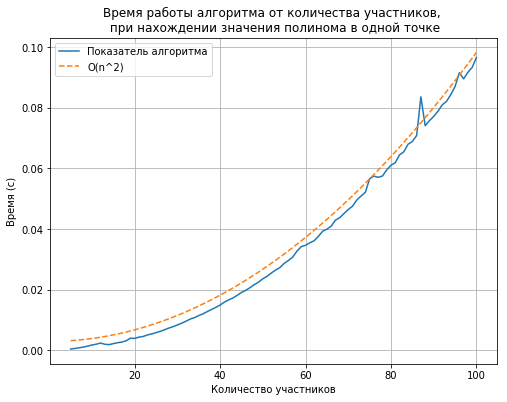

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(x, y, label=u"Показатель алгоритма")
plt.plot(x, [0.003+ i**2/105000 for i in x], label=u"O(n^2)", linestyle = "--")
plt.title(u"Время работы алгоритма от количества участников, \n при нахождении значения полинома в одной точке")
plt.xlabel(u"Количество участников")
plt.ylabel(u"Время (с)")
plt.grid()
plt.legend()
plt.show()

Видим, что эксперимент соответствует нашему утверждению.

### Сложность при явном вычислении всего случайного полинома
- Посмотрим, что будет если использовать интерполяцию для полного восстановления случайного полинома (сложность должна возрасти до $O(n^4)$ в силу сложности перемножения полиномов в нашей реализации)

In [19]:
x, y = secret_generation_timer(50, 4, explicit_poli = True)

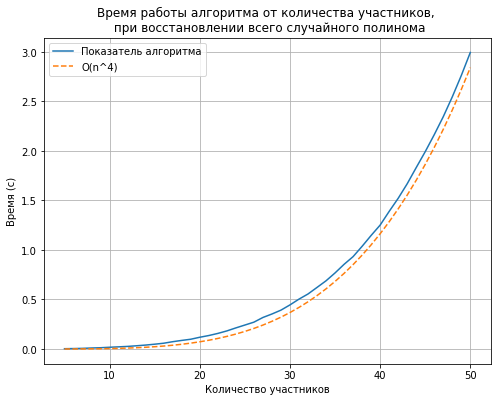

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(x, y, label=u"Показатель алгоритма")
plt.plot(x, [i**4/2200000 for i in x], label=u"O(n^4)", linestyle = "--")
plt.title(u"Время работы алгоритма от количества участников, \n при восстановлении всего случайного полинома")
plt.xlabel(u"Количество участников")
plt.ylabel(u"Время (с)")
plt.grid()
plt.legend()
plt.show()

Предположение подтвердилось, что делает нецелесообразным полное восстановление случайного полинома, поскольку для наших целей достаточно лишь значения в одной точке.

### Время работы алгоритма в зависимости от степени случайного полинома
- Поскольку сложность сложения полиномов линейно зависит от числа их слагаемых в канонической форме, сложность должна зависить от степени полинома линейно, проверим это. 

In [21]:
import timeit

def secret_generation_timer_degree(n, max_degree, explicit_poli = False):
    g = pn.generate_prime_number(random.randint(20,21))
    p = pn.generate_prime_number(random.randint(20,21))

    num = []
    t = []
    for degree in range(1, max_degree + 1):
        start_time = timeit.default_timer()

        crange = 10000
        secret_I, public_I, fs = secret_gen(n, g, p, crange, degree)
        x, y = secret_sharing(n, secret_I, fs, p)

        elapsed = (timeit.default_timer() - start_time)/n
        start_time = timeit.default_timer()
        
        if explicit_poli:
            secret_poli = interpolation_explicit(x, y)
        else:
            secret = interpolation_onepoint(x, y)

        elapsed += timeit.default_timer() - start_time
        
        num.append(degree)
        t.append(elapsed)
    return num, t

In [27]:
x, y = secret_generation_timer_degree(100, 99)

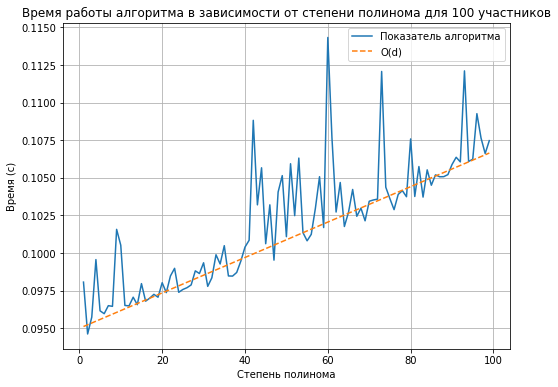

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(x, y, label=u"Показатель алгоритма")
plt.plot(x, [0.095 + i/8500 for i in x], label=u"O(d)", linestyle = "--")
plt.title(u"Время работы алгоритма в зависимости от степени полинома для 100 участников")
plt.xlabel(u"Степень полинома")
plt.ylabel(u"Время (с)")
plt.grid()
plt.legend()
plt.show()

Видим, что эксперимент соответствует утверждению.